# Setup and Initialisation of Energy Landscape graph

In [1]:
#data handling
import networkx as nx
import pandas as pd
import numpy as np

#other maths
import random
from collections import Counter
import math

#plotting
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import seaborn as sns



In [2]:
# select group for which to run analysis
b_in = "data/matlab_output/"
b_out = "data/ELA_output/"
# group_path = "ABIDE_ASD"
# group_path = "ABIDE_TD"
# group_path = "ABIDE_ASD_ADHD"
# group_path = "ADHD200_ADHD"
group_path = "ADHD200_TD"

## Init graph

In [3]:
# initialise a hypercube graph
g = nx.hypercube_graph(7)


# ADD ACTIVATION STATE DATA
# read in the activation states, such that energy values from the matlab code output can be correctly assigned to each activation state
activation_states = pd.read_csv(b_in+group_path+"/activation_states.csv", delimiter= "\t",header=None)
activation_states[activation_states==-1]=0 #aestetic change of binarisation for easier visual inspection

# states to dictionary
as_dict = pd.DataFrame.to_dict(activation_states,orient = "list")

# reverse dictionary such that (key:value) == (nx node name: ID in MAtlab data)
as_dict_correct = dict()
for key in as_dict.keys():
    #print(tuple(as_dict[key]))
    as_dict_correct[tuple(as_dict[key])]=key

# add ELA_ID values to the graph
nx.set_node_attributes(g, as_dict_correct, name="ELA_ID")

# example of ELA_ID retrieval
g.nodes[(0,1,0,0,0,1,0)]["ELA_ID"]

# ADD ENERGY VALUE DATA
# Read values to dict
EVk = pd.read_csv(b_in+group_path+"/EVk.csv", delimiter= "\t",header=None)
EVk_dict = pd.DataFrame.to_dict(EVk)[0]

# add EVk to relevant nodes
for node in g.nodes:
    ELA_key = g.nodes[node]["ELA_ID"]
    g.nodes[node]["EVk"] = EVk_dict[ELA_key]
    # set all to local minimum as default
    g.nodes[node]["local_minimum"] = True


# Calculation of Local Minima

In [4]:
for node in g.nodes:
    node_EVk = g.nodes[node]["EVk"]
    for nay in nx.neighbors(g,node):
        nay_EVk = g.nodes[nay]["EVk"]
        if nay_EVk<=node_EVk:
            # if any neighbour has a higher energy value the node is not a local minimum
            g.nodes[node]["local_minimum"] = False
        if nay_EVk==node_EVk:
            # to catch when two energy values are the same, as this is not expected behavior 
            print("EQUAL!")

#our local minima
min_df = pd.DataFrame(g.nodes("local_minimum"))
min_df = min_df[min_df[1]==True][0]
min_ids = [g.nodes[i]['ELA_ID'] for i in min_df]
print ("Local Minima activation states: \n",min_df)
print ("\n Local Minima ELA IDS: \n",min_ids)

min_df.to_csv(path_or_buf=b_out+group_path+"/min_df")
# example node
print("\n nodes now look like this:", g.nodes[(0,0,0,0,1,1,1)])

Local Minima activation states: 
 7      (0, 0, 0, 0, 1, 1, 1)
45     (0, 1, 0, 1, 1, 0, 1)
58     (0, 1, 1, 1, 0, 1, 0)
69     (1, 0, 0, 0, 1, 0, 1)
82     (1, 0, 1, 0, 0, 1, 0)
120    (1, 1, 1, 1, 0, 0, 0)
Name: 0, dtype: object

 Local Minima ELA IDS: 
 [63, 91, 85, 42, 36, 64]

 nodes now look like this: {'ELA_ID': 63, 'EVk': -1.64042081522957, 'local_minimum': True}


# Disconnectivity graphs


## calculation of disconnectivity graph

In [5]:
# initialise connected matrix, describing energy values at which local minima disconnect, if all nodes over that energy value are removed 
# initialised with -9999
connected_matrix = pd.DataFrame(-9999,index=min_ids, columns=min_ids,dtype=float)

#EVK sorted
EVk_removal_list = sorted(list(EVk_dict.values()))
connected = 999
#copy of graph to change
g_dis = g.copy()
prev_connected = 1000
all_stages_g = []
stages_g = [] 
while connected > 0:
    connected = 0
    # pop largest
    largest_EVk = EVk_removal_list.pop()
    selected = [x for x,y in g_dis.nodes(data=True) if y['EVk']==largest_EVk]
    if g_dis.nodes[selected[0]]["local_minimum"] == True:
        connected = 1
        continue # skips removal of local minima, moves on to remove next biggest instead

    # remove largest
    for n in selected:
        g_dis.remove_node(n)
    all_stages_g.append(g_dis.copy())
    #check connected
    for i in min_ids:
        for j in min_ids:
            if i==j:
                pass
            else:
                i_node = [x for x,y in g_dis.nodes(data=True) if y["ELA_ID"]==i][0]
                j_node = [x for x,y in g_dis.nodes(data=True) if y["ELA_ID"]==j][0]
                # check connected
                path_exists =  nx.has_path(g_dis,i_node,j_node)

                if path_exists:
                    connected+=1
                else:
                    # if not already changed then change ev value to max of matrix and EKV
                    if connected_matrix[i][j] <= -9999:
                    # store info
                        connected_matrix[i][j] = largest_EVk
                        connected_matrix[j][i] = largest_EVk
    if prev_connected != connected:
        # print("connections between minima: ", int(connected/2), "   number of connected components in graph: ", nx.number_connected_components(g_dis))
        stages_g.append(g_dis.copy())

    prev_connected = connected

print("The matrix after computing at which EVk, the  minima disconnect \n")

connected_matrix.to_csv(path_or_buf=b_out+group_path+"/connected_matrix")
connected_matrix

# the graph, at different stages is saved in the stages_g list 

The matrix after computing at which EVk, the  minima disconnect 



,63,91,85,42,36,64
63,-9999.000000,-1.165396,-0.851112,-1.537101,-0.851112,-0.851112
91,-1.165396,-9999.000000,-0.851112,-1.165396,-0.851112,-0.851112
85,-0.851112,-0.851112,-9999.000000,-0.851112,-1.056200,-1.454843
42,-1.537101,-1.165396,-0.851112,-9999.000000,-0.851112,-0.851112
36,-0.851112,-0.851112,-1.056200,-0.851112,-9999.000000,-1.056200
64,-0.851112,-0.851112,-1.454843,-0.851112,-1.056200,-9999.000000


## plotting setup

In [6]:
#g is used here to normalise globally across all graphs, such that positions and colours are consitant
#init positions for graphs

tsne = TSNE(n_components=2, random_state=42, init="pca",learning_rate="auto" ,perplexity=30)
tsne_positions = tsne.fit_transform(np.array(g.nodes))

iterations = 30
for steps in range (iterations):
    tsne_positions[:,1] = [g.nodes[i]["EVk"] for i in g.nodes()]
    tsne = TSNE(n_components=2, random_state=42,learning_rate="auto" ,perplexity=7+iterations-steps,init = tsne_positions)
    tsne_positions = tsne.fit_transform(np.array(g.nodes))
    tsne_positions[:,1] = [g.nodes[i]["EVk"] for i in g.nodes()]

positions = {}
for idx, node in enumerate(g.nodes):
    # Assign 2D position from PCA result
    positions[node] = (tsne_positions[idx, 0],tsne_positions[idx, 1]*3)
x_min,x_max = min([pos[0] for pos in positions.values()]),max([pos[0] for pos in positions.values()])
y_min,y_max = min([pos[1] for pos in positions.values()]),max([pos[1] for pos in positions.values()])


# init node colours for graphs
all_evk_values = nx.get_node_attributes(g, "EVk").values()

# Normalize EVk values
min_evk = min(all_evk_values)
max_evk = max(all_evk_values)
norm_colour = plt.Normalize(vmin=min_evk, vmax=max_evk+2)
colormap = cm.hot


C:\Users\nici9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


1


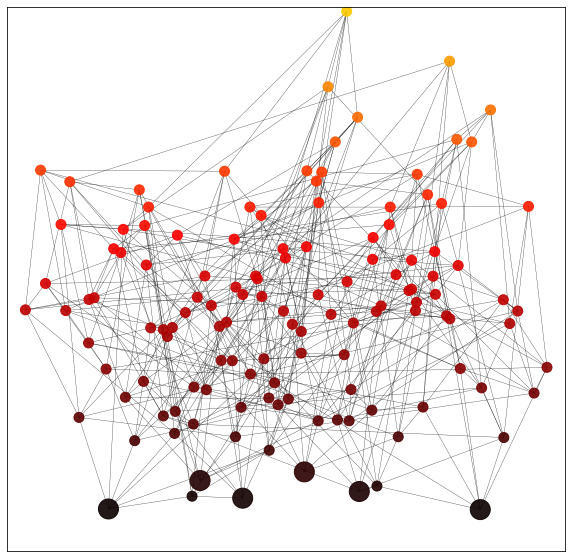

In [7]:
#plot
g_dis_draw = stages_g[0]
print(nx.number_connected_components(g_dis_draw))
fig = plt.figure(1, figsize=(10, 10))
plt.xlim(x_min-1,x_max+1)
plt.ylim(y_min-1,y_max)
node_colours = [colormap(norm_colour(i)) for i in nx.get_node_attributes(g_dis_draw, "EVk").values()]
node_sizes = [i*300+100 for i in nx.get_node_attributes(g_dis_draw, "local_minimum").values()]
nx.draw_networkx(g_dis_draw,with_labels=False,node_color = node_colours, node_size = node_sizes ,alpha = 0.9,width = 0.3,pos=positions)
fig.savefig(b_out+group_path+"/basic_graph.pdf",format="pdf")

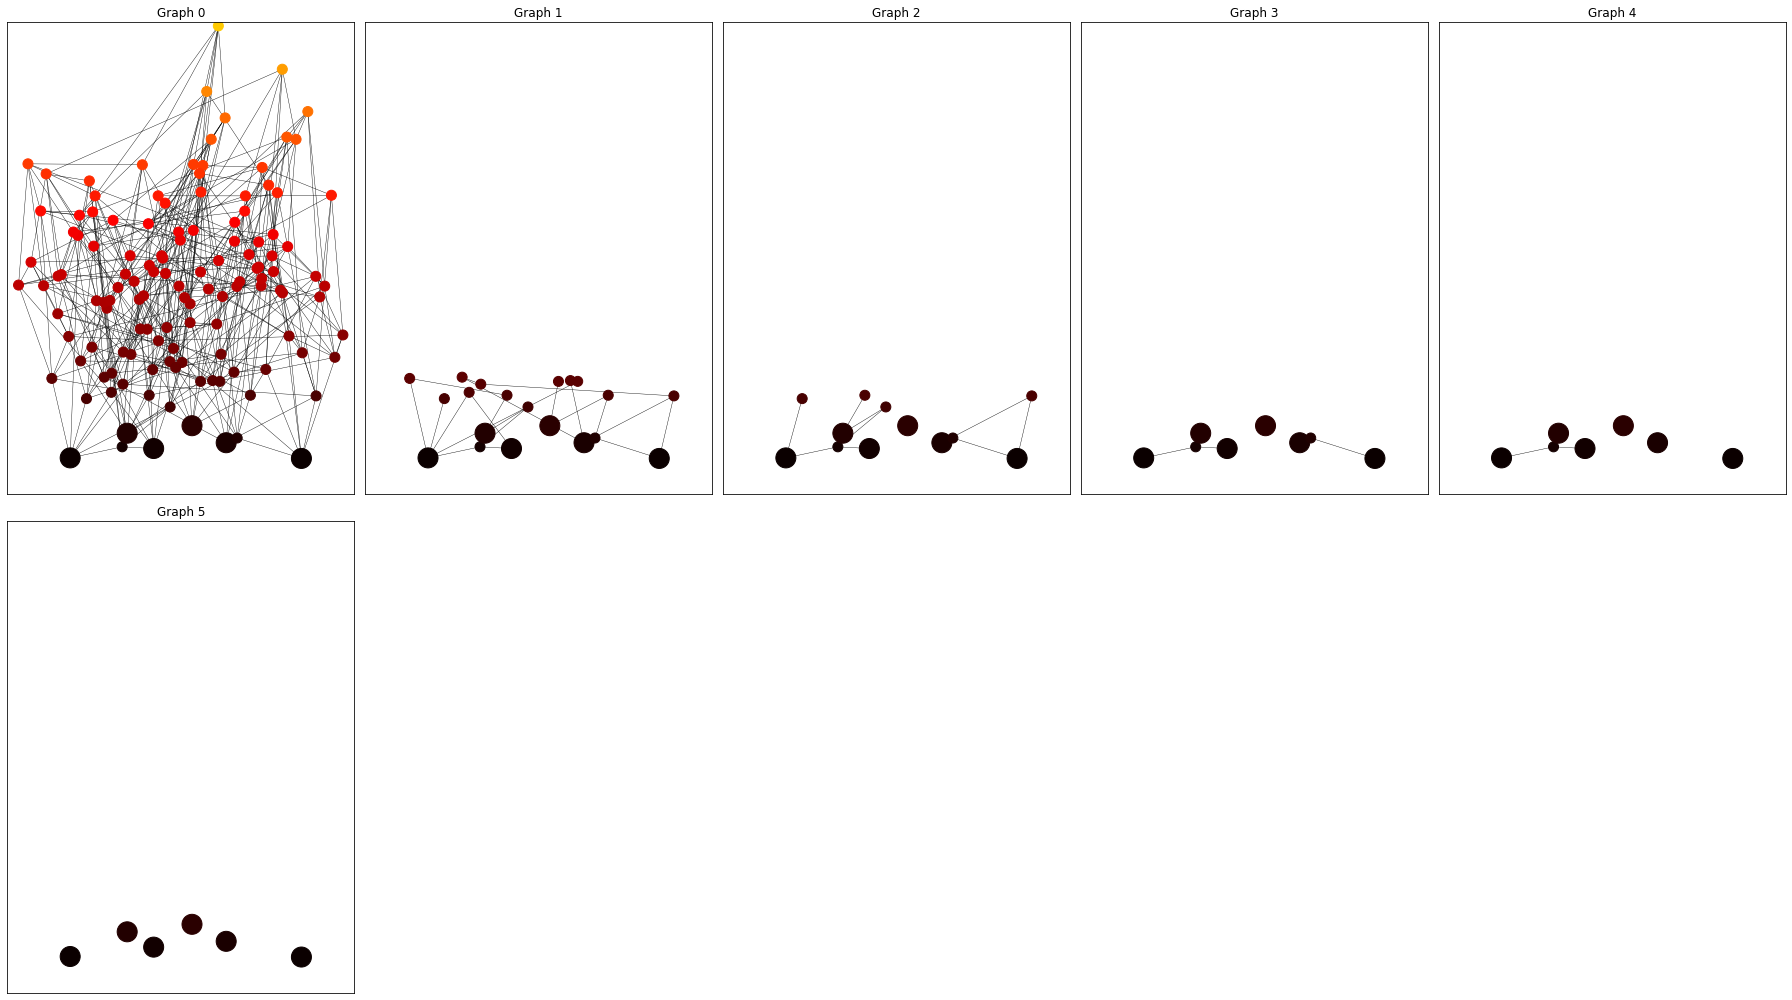

In [8]:

#graphs = all_stages_g[0:len(all_stages_g):10] # plot every 10th stage
#graphs = all_stages_g #plot all stages
graphs = stages_g # plot stages where new components appear

num_graphs = len(graphs)
cols = 5  # Number of columns for the subplots grid
rows = (num_graphs + cols - 1) // cols  # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(25, 7 * rows))
axes = axes.flatten() 


for i, g_dis_draw in enumerate(graphs):
    ax = axes[i]  # Select the subplot axis
    
    # Compute node sizes based on "local_minimum" attribute
    node_sizes = [(v * 300) + 100 for v in nx.get_node_attributes(g_dis_draw, "local_minimum").values()]
    node_colours = [colormap(norm_colour(i)) for i in nx.get_node_attributes(g_dis_draw, "EVk").values()]
    # Draw the graph with consistent layout and colors
    nx.draw_networkx(
        g_dis_draw,
        pos=positions,  # Use positions based on PCA
        ax=ax,
        node_color=node_colours,  # Use precomputed gradient colors based on global EVk values
        with_labels=False,
        node_size=node_sizes,
        alpha=1,
        width=0.4
    )
    ax.set_xlim(x_min-1,x_max+1)
    ax.set_ylim(y_min-1,y_max)
    ax.set_title(f"Graph {i}")

# Hide any unused subplots
for ax in axes[num_graphs:]:
    ax.axis("off")

plt.tight_layout()
plt.show()
fig.savefig(b_out+group_path+"/disconnectivity_stages.pdf",format="pdf")

## plot disconnectivity graph

In [9]:
all_found_minima = [35,36,39,42,43,52,63,64,75,85,84,88,91,92]
node_categories = {node: idx for idx, node in enumerate(all_found_minima)} # Map nodes to categories found in all graphs (for consistency, will need amending if different local minima found)


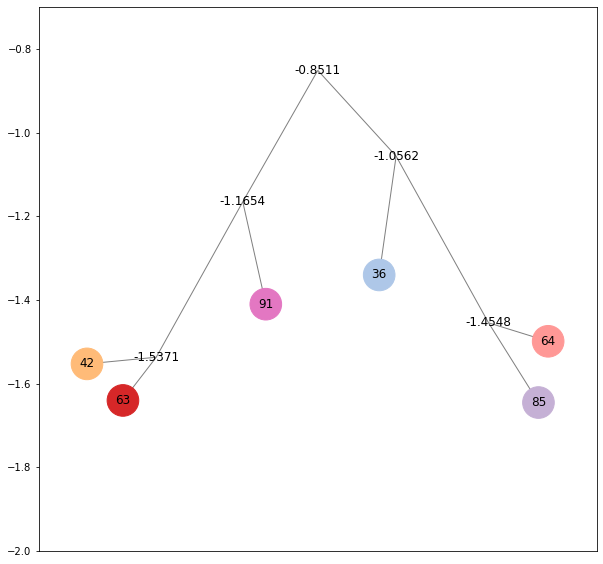

In [ ]:
EVk_disconnection_values = sorted(set(connected_matrix.values.flatten()))[1:]
disconnectivity_graph = nx.Graph()
for node_id in min_ids:
    g.nodes[(0,0,0,1,0,0,0)]["EVk"]
    node_state =  [x for x,y in g.nodes(data=True) if y["ELA_ID"]==node_id][0]
    disconnectivity_graph.add_node(node_id, activation_state = node_state,node_type = "activation",EVk = g.nodes[node_state]["EVk"] )

min_ids_not_in_graph = min_ids.copy()
for i in EVk_disconnection_values:
    disconnectivity_graph.add_node(f"{round(i,4)}", activation_state = None,node_type = "connection",EVk = i )

for node_a in min_ids:
    connect_these = sorted(set(connected_matrix[node_a]),reverse=True)
    self_connection = connect_these.pop()
    lowest = connect_these.pop()
    disconnectivity_graph.add_edge(f"{round(lowest,4)}",node_a)
    while connect_these:
        new_lowest = connect_these.pop()
        disconnectivity_graph.add_edge(f"{round(lowest,4)}",f"{round(new_lowest,4)}")
        lowest=new_lowest

# tree subsets for plot 
for node in disconnectivity_graph.nodes():
    disconnectivity_graph.nodes()[node]["subset"] = 999
    for nn in nx.all_neighbors(disconnectivity_graph,node):
        if disconnectivity_graph.nodes()[nn]["EVk"]>disconnectivity_graph.nodes()[node]["EVk"]:
            disconnectivity_graph.nodes()[node]["subset"] = float(nn)
subset_mapping = {i:x for x,i in enumerate(sorted(set(nx.get_node_attributes( disconnectivity_graph,"subset").values()))) }

node_subset_mapping = {node: subset_mapping[disconnectivity_graph.nodes()[node]["subset"]] for node in disconnectivity_graph.nodes()}
nx.set_node_attributes(disconnectivity_graph,values= node_subset_mapping, name = "subset")

fig, ax= plt.subplots(1, figsize=(10, 10))

spring_positions = nx.spring_layout(disconnectivity_graph, seed=specific_layout)  # Generate layout for x-axis #39 for abide comorbid 41 for asd use 42 for abide TD use 40 , 36
dis_positions = {node: (spring_positions[node][0], attrs["EVk"]) 
             for node, attrs in disconnectivity_graph.nodes(data=True)}

node_colours = [ cm.tab20(node_categories[node]) if node in all_found_minima else (0,0,0,0)  for node in  disconnectivity_graph.nodes]

nx.draw_networkx(disconnectivity_graph,with_labels=True,node_color= node_colours,pos=dis_positions,node_size =1000,edge_color = "gray",ax=ax)
ax.tick_params(left=True, labelleft=True)
ax.set_ylim(-2,-0.7)
fig.savefig(b_out+group_path+"/disconnectivity_graph.pdf",format="pdf")


# Classification of nodes to basins

## remove upward edges

In [11]:
g_c = g.copy()
g_c = g_c.to_directed()
copy_of_edges = list(g_c.edges())
for edge in copy_of_edges:
    if g_c.nodes()[edge[0]]["EVk"]<=g_c.nodes()[edge[1]]["EVk"]:
        g_c.remove_edge(edge[0],edge[1])
    node

### plot only down edges

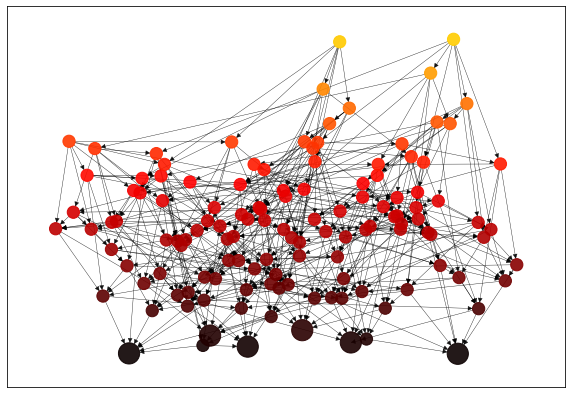

In [12]:
plot_g = g_c
fig = plt.figure(1, figsize=(10, 7))
edge_max_EVk = [max([plot_g.nodes[i[0]]["EVk"],plot_g.nodes[i[1]]["EVk"]]) for i in plot_g.edges()]
edge_colours = [colormap(norm_colour(i)) for i in edge_max_EVk]
node_sizes = [i*300+150 for i in nx.get_node_attributes(plot_g, "local_minimum").values()]
node_colours = [colormap(norm_colour(i)) for i in nx.get_node_attributes(plot_g, "EVk").values()]
ax.tick_params(left=True, labelleft=True)
nx.draw_networkx(plot_g,node_color=node_colours,with_labels=False,node_size = node_sizes,alpha = 0.9,width = 0.4,pos=positions)
fig.savefig(b_out+group_path+"/_graph_downedges.pdf",format="pdf")


In [13]:
g_c2 = g_c.copy()
for node in g_c2.nodes:
    if g_c2.nodes()[node]["local_minimum"] == False:
        n_EVks = dict()
        for n_node in g_c2.neighbors(node):
            # print(g_c2.nodes()[n_node]["EVk"])
            n_EVks[g_c2.nodes()[n_node]["EVk"]] = node
        min_n_EVk = min(n_EVks.keys())
        # print("Keep only", min_n_EVk)
        neigh_list = [i for i in g_c2.neighbors(node)]
        for n_node in neigh_list:
            if g_c2.nodes()[n_node]["EVk"]!=min_n_EVk:
                g_c2.remove_edge(node,n_node)


## keep only lowest edge

In [14]:
# basin as attribute
g_c2_b = g_c2.copy()
nx.set_node_attributes(g_c2_b,"none",name="basin")
def get_basin(node):
    if g_c2_b.nodes[node]["local_minimum"]==True:
        g_c2_b.nodes[node]["basin"]=node
        return node
    else:
        basin = get_basin([i for i in g_c2_b.neighbors(node)][0])
        g_c2_b.nodes[node]["basin"]=basin
        return basin 

for node in g_c2_b.nodes():
    get_basin(node)

#adjust position by basin
basin_pos_adjust = {j:x*30 for x,j in enumerate(set([g_c2_b.nodes[i]["basin"] for i in g_c2_b.nodes]))}
positions2 = positions.copy()
for i in g_c2:
    basin_of_i = g_c2_b.nodes[i]["basin"]
    positions2[i] = (positions2[i][0]+basin_pos_adjust[basin_of_i],positions2[i][1])


### plot by basin

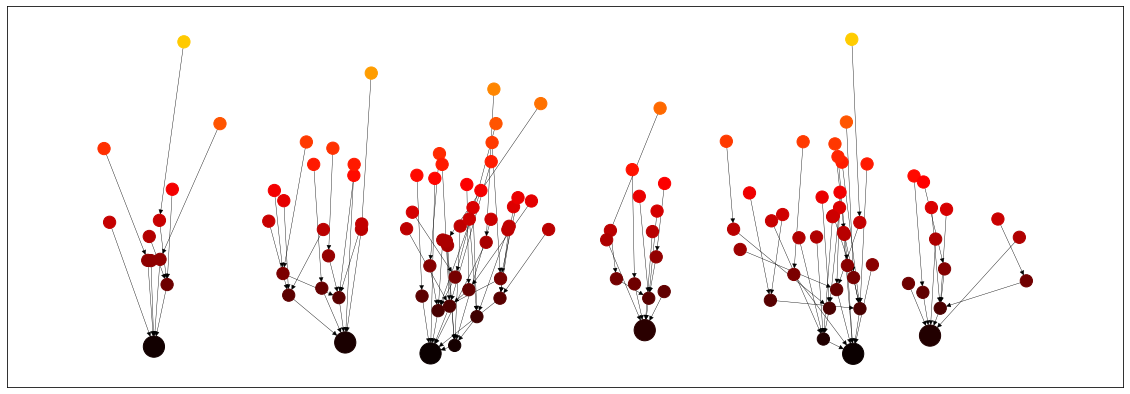

In [15]:
plot_g = g_c2_b
fig = plt.figure(1, figsize=(20, 7))
nx.draw_networkx(plot_g,node_color=node_colours,with_labels=False,node_size = node_sizes,alpha = 1,width = 0.4,pos=positions2)
fig.savefig(b_out+group_path+"/graph_basins.pdf",format="pdf")


## Active Regions in each basin

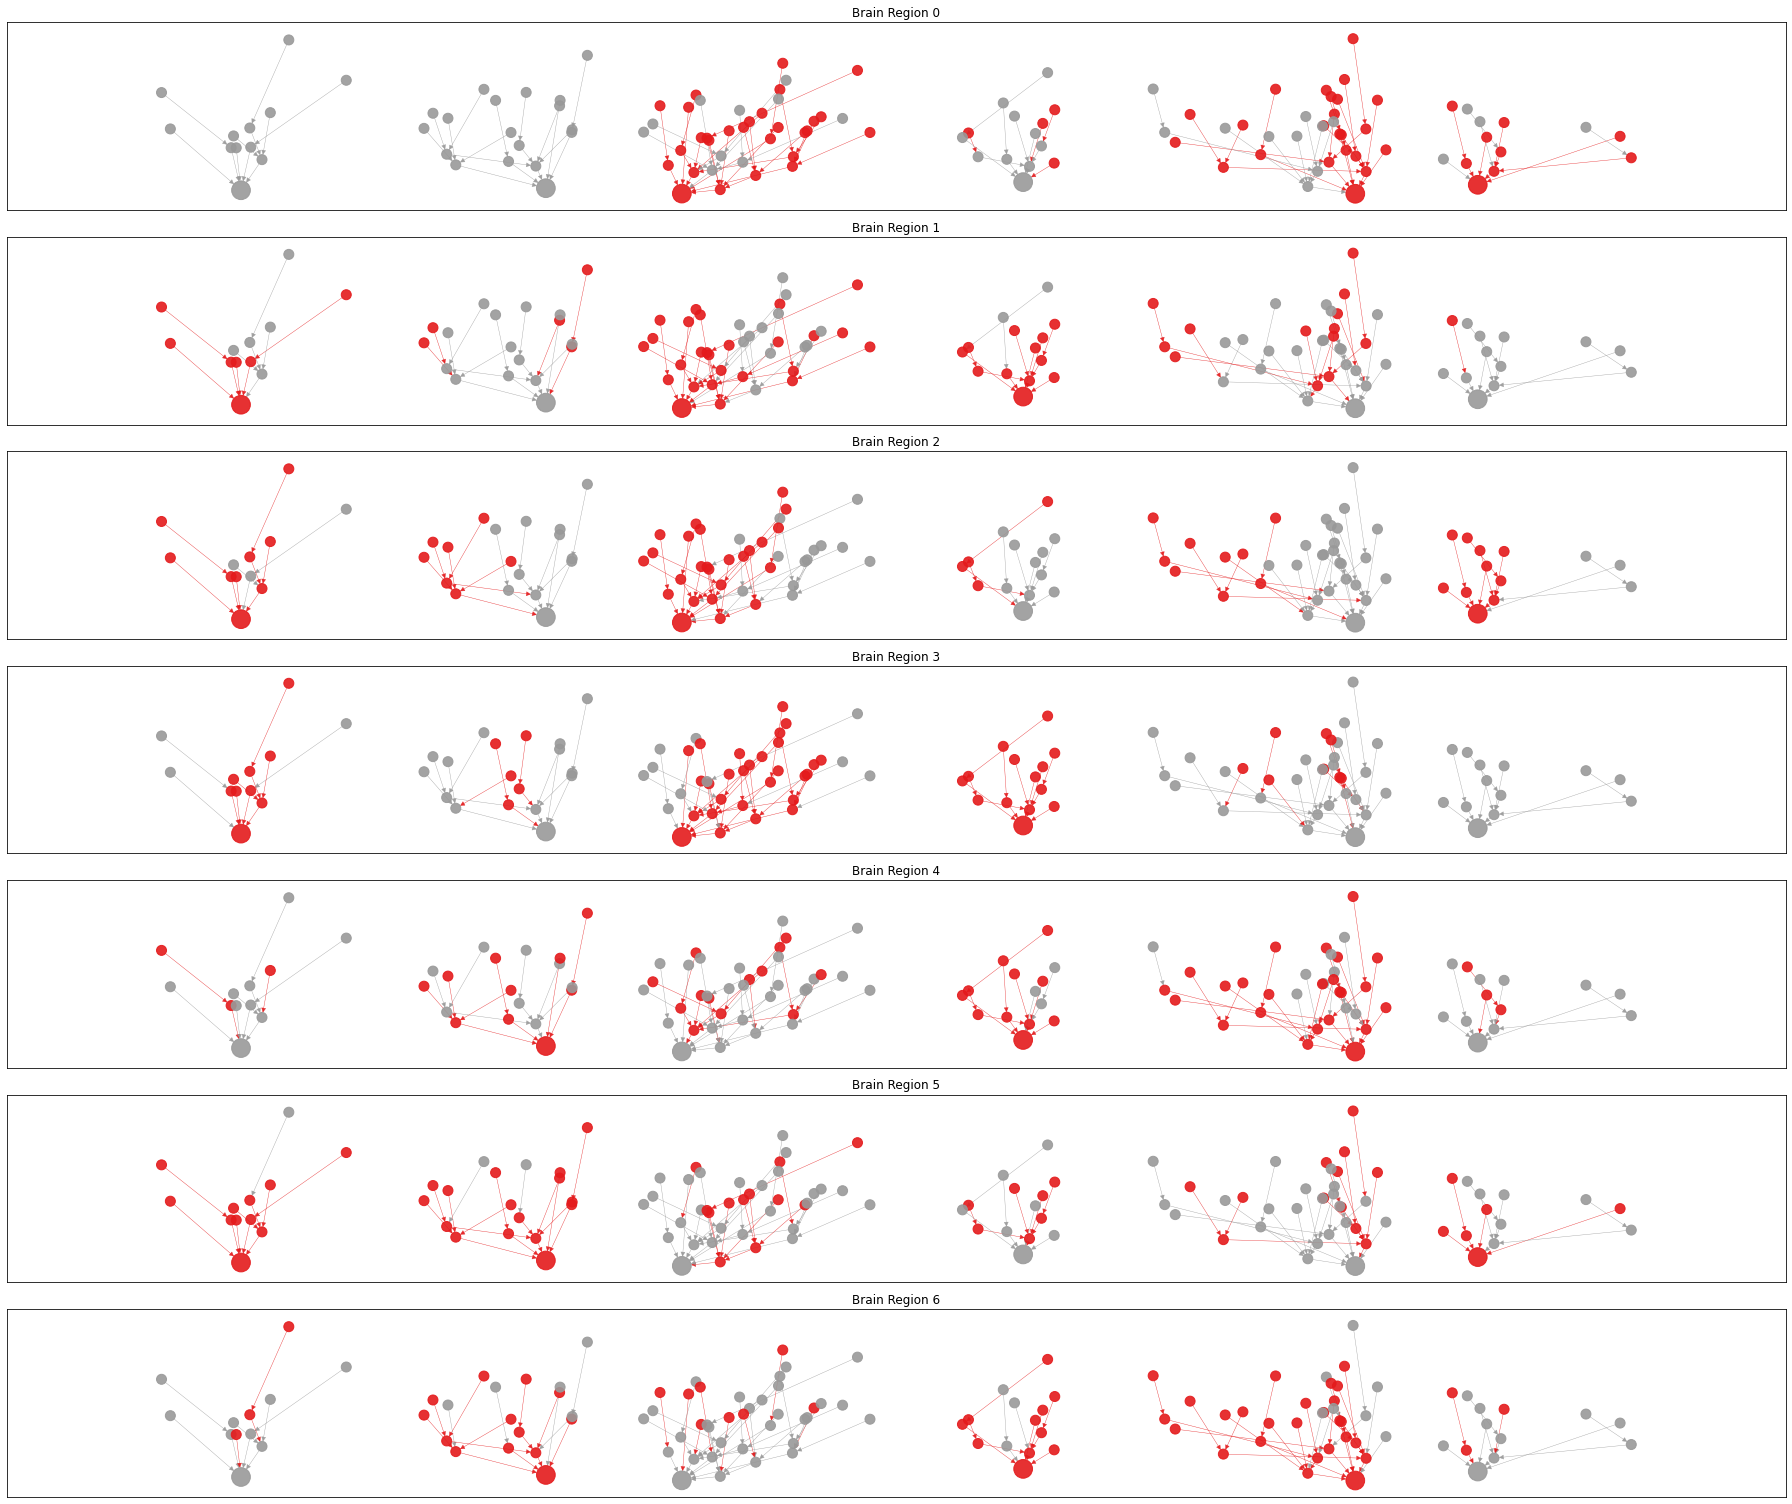

In [16]:

# Set up the main graph and categories
plot_g = g_c2_b
brain_region = 5  # The index of the attribute indicating the brain region

# Get the unique brain region categories
unique_categories = [i for i in range(7)]
color_palette = cm.get_cmap("Set1", 2)
category_to_color = {cat: color_palette(i) for i, cat in enumerate(unique_categories)}

# Set up subplots
num_categories = len(unique_categories)
cols = 1  # Number of columns in the subplot grid
rows = (num_categories + cols - 1) // cols  # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(25, 3 * rows))
axes = axes.flatten()

# Iterate over unique brain regions and create subplots
for idx, category in enumerate(unique_categories):
    ax = axes[idx]

    region_or_not = set([node[category] for node, attrs in plot_g.nodes(data=True)])

    node_colors = [category_to_color[node[category]] for node in plot_g.nodes]

    node_sizes = [(v * 250) + 100 for v in nx.get_node_attributes(plot_g, "local_minimum").values()]
    edge_colors = [category_to_color[edge[0][category]]  for edge in plot_g.edges]  # Use the source node color
    min_nodes_names = [i for i in g_c2_b.nodes if g_c2_b.nodes[i]["local_minimum"]==True]
    pos_min_dict = {i: (1 + x % 3, (x >= 3) + 1) for x, i in enumerate(min_nodes_names)}
    nx.draw_networkx(plot_g,ax=ax,node_color=node_colors, with_labels=False,node_size = node_sizes,alpha = 0.9,width = 0.4,pos= positions2,edge_color= edge_colors)
    ax.set_title(f"Brain Region {category}")

# Hide any unused subplots
for ax in axes[num_categories:]:
    ax.axis("off")
plt.tight_layout()
plt.show()
fig.savefig(b_out+group_path+"/graph_region_activations.pdf",format="pdf")



In [17]:
plot_g.nodes()[min_nodes_names[0]]

{'ELA_ID': 63,
 'EVk': -1.64042081522957,
 'local_minimum': True,
 'basin': (0, 0, 0, 0, 1, 1, 1)}

In [18]:
plot_g = g_c2_b
regions = range(7)
region_activation = pd.DataFrame(data = 0, index = [plot_g.nodes()[name]["ELA_ID"] for name in min_nodes_names], columns= regions,dtype=float)
for i in regions:
    for basin in min_nodes_names:
        basin_ID = plot_g.nodes()[basin]["ELA_ID"]
        relevant = [node[i] for node in plot_g.nodes if plot_g.nodes[node]["basin"] == basin ]
        region_activation[i][basin_ID] = sum(relevant)/len(relevant)

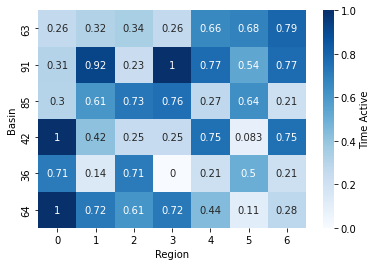

In [19]:
fig, ax = plt.subplots()
sns.heatmap(region_activation, annot=True,cmap="Blues", cbar_kws={'label': 'Time Active'});
ax.set_xlabel("Region")
ax.set_ylabel("Basin")
fig.savefig(b_out+group_path+"/region_activation_heatmap.pdf",format="pdf")
#region percentage time active

# Random walk

## Simulation

In [20]:

# graph with all edges
rw_g = g.copy() #g_c2_b has basin data for lookup, but we want to random walk on the actual graph (no edges removed)
rw_g.nodes(data=True)
#choose random neighbour, then move to there with probabiliry min[e^(ei-ej)]
current_node = random.choice(list(rw_g.nodes))
# set random seed
path = []
path_basins= []
# choose a random start node
while len(path)<100000:
    chosen_neighbour = random.choice([n for n in rw_g.neighbors(current_node)])
    current_node_EVk = rw_g.nodes[current_node]["EVk"]
    neighbour_node_EVk = rw_g.nodes[chosen_neighbour]["EVk"]
    chance = min (1,pow(math.e,current_node_EVk-neighbour_node_EVk))
    prob = random.uniform(0, 1)
    if prob<chance:
        current_node = chosen_neighbour
        path.append(chosen_neighbour)
        path_basins.append(g_c2_b.nodes[chosen_neighbour]["basin"])


In [21]:

easier_names = dict()
easier_names = {i: f"{g.nodes[i]['ELA_ID']}" for i in set(path_basins[100:])}
letters = [i for i in easier_names.values()]

# Replace occurrences in the sliced list
replaced_basins = [easier_names[item] for item in path_basins[100:]]
# use abcd instead, easier
# group the occurences for easier analyisis
last_basin= "Start"
current_counter = 0
basins_grouped=[]
for i in replaced_basins:
    current_basin = i
    current_counter+=1
    if last_basin != current_basin:
        basins_grouped.append([last_basin,current_counter])
        current_counter = 0
    last_basin = current_basin
basins_grouped.append([last_basin,current_counter+1])
basins_grouped = basins_grouped[1:]
#calculate dwelling time # how long in each state
# calculate transition frequency from state to state
print(basins_grouped)



[['91', 1], ['64', 3], ['85', 1], ['36', 1], ['85', 1], ['63', 1], ['85', 1], ['63', 1], ['85', 2], ['36', 2], ['64', 1], ['85', 1], ['64', 2], ['91', 1], ['42', 3], ['63', 1], ['91', 4], ['85', 2], ['91', 1], ['85', 8], ['64', 1], ['85', 1], ['64', 1], ['36', 3], ['85', 2], ['36', 2], ['64', 2], ['85', 4], ['91', 1], ['63', 1], ['85', 1], ['63', 1], ['91', 1], ['64', 1], ['91', 4], ['63', 2], ['42', 1], ['63', 1], ['42', 2], ['91', 1], ['64', 2], ['85', 1], ['64', 8], ['36', 3], ['64', 1], ['42', 1], ['64', 1], ['91', 1], ['64', 3], ['85', 3], ['91', 4], ['85', 1], ['64', 1], ['85', 1], ['91', 3], ['85', 12], ['91', 1], ['63', 5], ['42', 1], ['63', 7], ['91', 2], ['64', 1], ['91', 1], ['85', 2], ['91', 2], ['63', 1], ['91', 1], ['64', 5], ['42', 1], ['63', 1], ['42', 1], ['64', 10], ['85', 4], ['64', 2], ['85', 2], ['64', 1], ['85', 10], ['91', 6], ['85', 4], ['64', 2], ['85', 11], ['64', 2], ['36', 2], ['64', 1], ['85', 1], ['63', 12], ['85', 1], ['63', 3], ['36', 1], ['85', 3], ['36

In [22]:
states_grouped_transitions = {l:[] for l in letters}
states_grouped_dwell = {l:[] for l in letters}

last_state = None
first = True
for i in basins_grouped:
    states_grouped_dwell[i[0]].append(i[1])
    if not first:
        states_grouped_transitions[last_state[0]].append(i[0])
    first = False
    last_state = i


## Dwelling time 

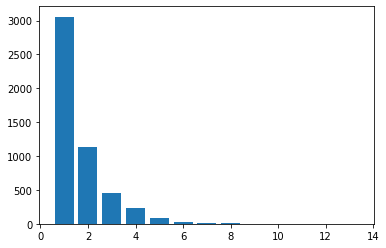

In [23]:
fig, ax = plt.subplots()
dwell_plot_dict = Counter(states_grouped_dwell[letters[0]])
plt.bar(dwell_plot_dict.keys(),dwell_plot_dict.values())
fig.savefig(b_out+group_path+"/dwelling_time_bar_state_b.pdf",format="pdf")

In [24]:
for l in letters:
    print(l,"mean dwelling time",np.mean(states_grouped_dwell[l]),"variance of dwelling time",np.var(states_grouped_dwell[l]))


42 mean dwelling time 1.675234110380554 variance of dwelling time 1.189207332121997
64 mean dwelling time 1.994041085149757 variance of dwelling time 2.4337107670120264
63 mean dwelling time 2.784513692162417 variance of dwelling time 7.50332957936871
36 mean dwelling time 1.799074074074074 variance of dwelling time 1.7148756858710565
85 mean dwelling time 2.627731346289397 variance of dwelling time 5.549564272201379
91 mean dwelling time 1.8410215482841181 variance of dwelling time 1.910240616455065


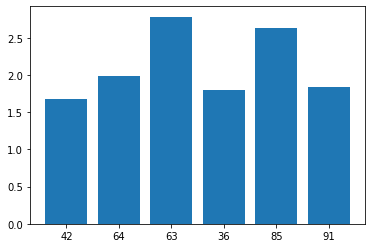

In [25]:
fig, ax = plt.subplots()
plt.bar(letters, [np.mean(states_grouped_dwell[l])for l in letters])
fig.savefig(b_out+group_path+"/avg_dwelling_time_bar.pdf",format="pdf")

In [26]:
for l in letters:
    print(l,Counter(states_grouped_transitions[l]))
#b and c most stable, refer back and align with 2 most stable from paper a and be are these the same??

42 Counter({'63': 2789, '64': 1085, '36': 824, '91': 321})
64 Counter({'85': 3111, '42': 1095, '91': 1077, '36': 1054, '63': 40})
63 Counter({'42': 2736, '36': 2721, '85': 2573, '91': 2509, '64': 51})
36 Counter({'63': 2667, '85': 1890, '64': 1060, '42': 863})
85 Counter({'64': 3090, '63': 2602, '91': 2357, '36': 1881})
91 Counter({'63': 2492, '85': 2357, '64': 1091, '42': 325})


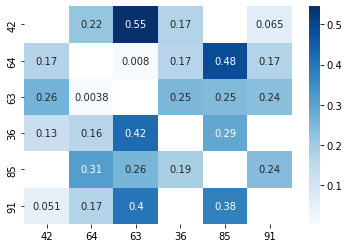

In [27]:
transition_matrix = pd.DataFrame({l:Counter(states_grouped_transitions[l]) for l in letters},columns=letters,index=letters)
transition_matrix_av = (transition_matrix+transition_matrix.T)/2
transition_matrix_n = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)#normalise
fig, ax = plt.subplots()
sns.heatmap(transition_matrix_n, annot=True,cmap="Blues")
fig.savefig(b_out+group_path+"/transition_heatmap.pdf",format="pdf")

## ELA Transition Graph

### Undirected

In [28]:
G_ST = nx.from_pandas_adjacency(transition_matrix_av)
G_ST.remove_edges_from(nx.selfloop_edges(G_ST))

In [29]:
all_found_minima

[35, 36, 39, 42, 43, 52, 63, 64, 75, 85, 84, 88, 91, 92]

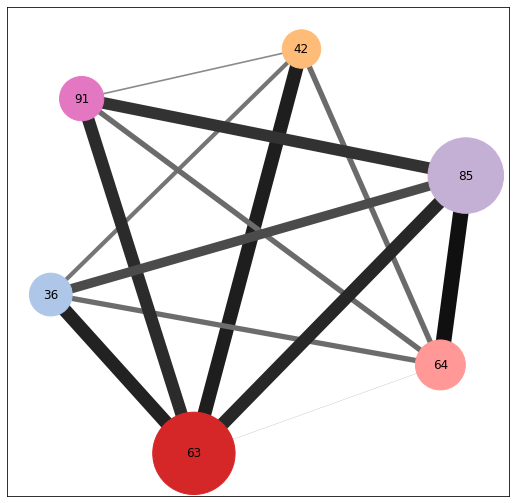

In [30]:
fig = plt.figure(figsize = (9,9))
weights =  nx.get_edge_attributes(G_ST,'weight')
edge_weights_GST = [weights[i]/200 for i in G_ST.edges]
edge_c_GST = [(i/35)+0.5 for i in edge_weights_GST]
#scale dwelling time to node area
node_size_GST = [np.mean(states_grouped_dwell[i])**3*314 for i in G_ST.nodes]
node_colours = [ cm.tab20(node_categories[int(node)]) for node in  G_ST.nodes]
nx.draw_networkx(G_ST, edge_color= cm.Greys(edge_c_GST), width = edge_weights_GST, pos= nx.spring_layout(G_ST, seed=42,k=100), node_color = node_colours, node_size = node_size_GST,connectionstyle ="arc3,rad=0.08"  )
fig.savefig(b_out+group_path+"/dwell_transition_graph.pdf",format="pdf")

### Directed

In [31]:
G_ST_dir = nx.from_pandas_adjacency(transition_matrix_av,create_using=nx.DiGraph())
G_ST_dir.remove_edges_from(nx.selfloop_edges(G_ST_dir))

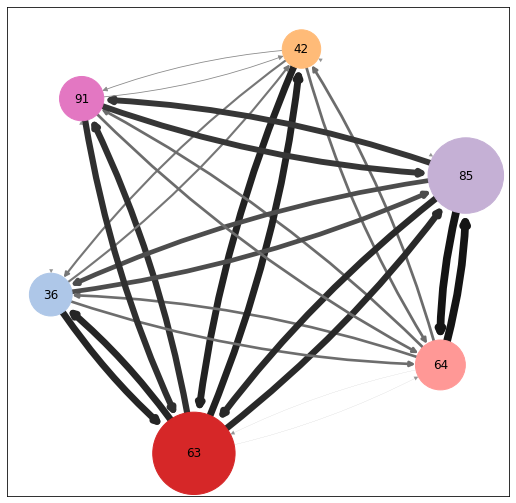

In [32]:
fig = plt.figure(figsize = (9,9))
weights =  nx.get_edge_attributes(G_ST_dir,'weight')
edge_weights_GST = [weights[i]/400 if weights[i]>0 else 0 for i in G_ST_dir.edges ]
edge_c_GST = [(i/18)+0.5 for i in edge_weights_GST]

#scale dwelling time to node volume if sphere (more intuitive)
node_size_GST = [(np.mean(states_grouped_dwell[i])**3)*314 for i in G_ST_dir.nodes]
node_colours = [ cm.tab20(node_categories[int(node)]) for node in  G_ST_dir.nodes]

nx.draw_networkx(G_ST_dir, edge_color= cm.Greys(edge_c_GST), width = edge_weights_GST, pos= nx.spring_layout(G_ST_dir, seed=42,k =100), node_color = node_colours, node_size = node_size_GST,connectionstyle ="arc3,rad=0.08"  )
fig.savefig(b_out+group_path+"/dwell_transition_graph_directed.pdf",format="pdf")